In [1]:
import pandas as pd
import numpy as np

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)


module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_feature_values(feature_values):

    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        X_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )
    
def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = X_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(X_train):
    
    X_normalized_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

    return X_normalized_train

In [3]:
ist3 = pd.read_sas("data/datashare_aug2015.sas7bdat")

continuous_vars = [
                    "gender",
                    "age",
                    "weight",
                    "glucose",
                    "gcs_eye_rand",
                    "gcs_motor_rand",
                    "gcs_verbal_rand",
                    # "gcs_score_rand",   
                     "nihss" ,
                     "sbprand",
                     "dbprand",
                  ]

cate_variables = [
                     # "livealone_rand",
                     # "indepinadl_rand",
                     "infarct",
                     "antiplat_rand",
                     # "atrialfib_rand",
                    #  "liftarms_rand",
                    # "ablewalk_rand",
                    # "weakface_rand",
                    # "weakarm_rand",
                    # "weakleg_rand",
                    # "dysphasia_rand",
                    # "hemianopia_rand",
                    # "visuospat_rand",
                    # "brainstemsigns_rand",
                    # "otherdeficit_rand",
                    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

In [4]:
x = ist3[continuous_vars + cate_variables + treatment]

x = pd.get_dummies(x, columns=cate_variables)

n, feature_size = x.shape


names = x.drop(["itt_treat"], axis=1).columns
treatment_index = x.columns.get_loc("itt_treat")
var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=10,
                                    )


w_train = X_train[:, treatment_index] == 0
w_test =  X_test[:, treatment_index] == 0

X_train = X_train[:,var_index]
X_test = X_test[:, var_index]

y_train = y_train ==0
y_test = y_test ==0

In [5]:
model = pseudo_outcome_nets.XLearner(  
                                        X_train.shape[1],
                                        binary_y=(len(np.unique(y_train)) == 2),
                                        n_layers_out=2,
                                        n_units_out=100,
                                        batch_size=128,
                                        n_iter=1000,
                                        nonlin="relu",
                                        device="cuda:1",
                                        )

model.fit(X_train, y_train, w_train)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.23611454665660858, train_loss: 0.28286224603652954
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.0310980174690485, train_loss: 0.02066834643483162
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.02046041190624237, train_loss: 0.007654974237084389
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.017096446827054024, train_loss: 0.005556951276957989
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.016182323917746544, train_loss: 0.0055465674959123135
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 1.0358144044876099, train_loss: 0.9752740859985352
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.04566369950771332, train_loss: 0.018144460394978523
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.03667725622653961, train_loss: 0.008185778744518757
[po_estimator_1_impute_pos] Epoch: 150, current validatio

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_propensity_estimator): PropensityNet(
  

100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.22s/it]


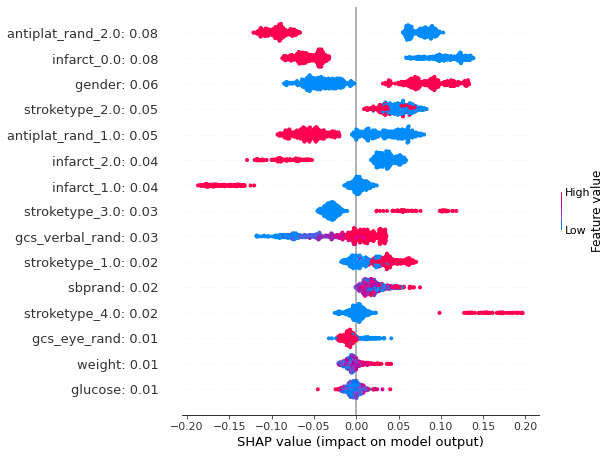

In [6]:
learner_explanations = {}

learner_explanations["shapley_sampling"] = np.zeros((X_test.shape))
marginal_extension = removal.MarginalExtension(X_test, model)

for test_ind in range(len(X_test)):
    instance = X_test[test_ind]
    game = games.PredictionGame(marginal_extension, instance)
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
    learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, X_test.shape[1])

plot_feature_values(learner_explanations["shapley_sampling"])

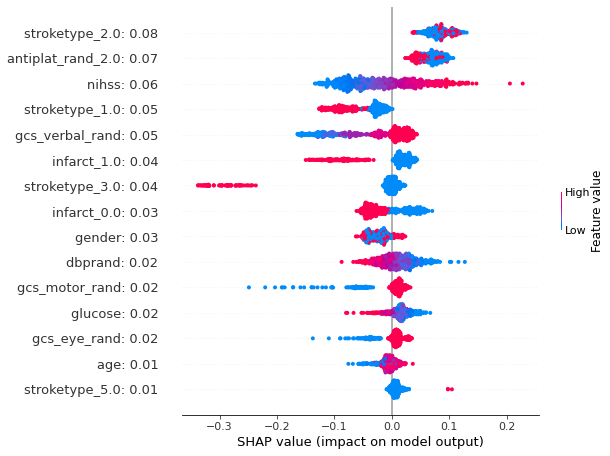

In [10]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [ ]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(X_test).to("cuda:1").requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

In [ ]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(X_test).to("cuda:1").requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])